## Predicting Walmart's Quarterly Earnings - Pytorch LSTM Example
### Applying LSTMs to Predict Quarterly Earnings

This is the code accompanying my Medium article which you can find linked in the ReadMe. The code blocks follow the same pattern as those in the article!

In [1]:
#-- Necessary Imports
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import datetime as dt

import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline

In [109]:
df = pd.read_csv('SBUX.csv', index_col = 'Date', parse_dates=True)
df = df.iloc[:200, 3:4]
df

,Close
Date,
2019-12-11,86.589996
2019-12-12,88.209999
2019-12-13,88.669998
2019-12-16,88.779999
2019-12-17,88.129997
...,...
2020-09-21,83.889999
2020-09-22,83.949997
2020-09-23,82.989998


In [110]:
def train_test(df, test_periods):
    train = df[:-test_periods].values
    test = df[-test_periods:].values
    return train, test
test_periods = 10
train, test = train_test(df, test_periods)

In [111]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(train)
train_scaled = scaler.transform(train)

In [112]:
train_scaled = torch.FloatTensor(train_scaled)
print(f'Original dimensions : {train_scaled.shape}')
train_scaled = train_scaled.view(-1)
print(f'Correct dimensions : {train_scaled.shape}')

Original dimensions : torch.Size([190, 1])
Correct dimensions : torch.Size([190])


In [113]:
def get_x_y_pairs(train_scaled, train_periods, prediction_periods):
    """
    train_scaled - training sequence
    train_periods - How many data points to use as inputs
    prediction_periods - How many periods to ouput as predictions
    """
    x_train = [train_scaled[i:i+train_periods] for i in range(len(train_scaled)-train_periods-prediction_periods)]
    y_train = [train_scaled[i+train_periods:i+train_periods+prediction_periods] for i in range(len(train_scaled)-train_periods-prediction_periods)]
    
    #-- use the stack function to convert the list of 1D tensors
    # into a 2D tensor where each element of the list is now a row
    x_train = torch.stack(x_train)
    y_train = torch.stack(y_train)
    
    return x_train, y_train

train_periods = 30 #-- number of values for input
prediction_periods = test_periods
x_train, y_train = get_x_y_pairs(train_scaled, train_periods, prediction_periods)
print(x_train.shape)
print(y_train.shape)

torch.Size([150, 30])
torch.Size([150, 10])


In [114]:
class LSTM(nn.Module):
    """
    input_size - will be 1 in this example since we have only 1 predictor (a sequence of previous values)
    hidden_size - Can be chosen to dictate how much hidden "long term memory" the network will have
    output_size - This will be equal to the prediciton_periods input to get_x_y_pairs
    """
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        
        self.lstm = nn.LSTM(input_size, hidden_size)
        
        self.linear = nn.Linear(hidden_size, output_size)
        
    def forward(self, x, hidden=None):
        if hidden==None:
            self.hidden = (torch.zeros(1,1,self.hidden_size),
                           torch.zeros(1,1,self.hidden_size))
        else:
            self.hidden = hidden
            
        """
        inputs need to be in the right shape as defined in documentation
        - https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html
        
        lstm_out - will contain the hidden states from all times in the sequence
        self.hidden - will contain the current hidden state and cell state
        """
        lstm_out, self.hidden = self.lstm(x.view(len(x),1,-1), 
                                          self.hidden)
        
        predictions = self.linear(lstm_out.view(len(x), -1))
        
        return predictions[-1], self.hidden

In [125]:
model = LSTM(input_size=1, hidden_size=5, output_size=test_periods)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [129]:
epochs = 100
model.train()
for epoch in range(epochs+1):
    for x,y in zip(x_train, y_train):
        y_hat, _ = model(x)
        optimizer.zero_grad()
        loss = criterion(y_hat, y)
        loss.backward()
        optimizer.step()
        
    if epoch%20==0:
        print(f'epoch: {epoch:4} loss:{loss.item():10.8f}')

epoch:    0 loss:0.02024824
epoch:   20 loss:0.01966180
epoch:   40 loss:0.01855633
epoch:   60 loss:0.01878710
epoch:   80 loss:0.01996206
epoch:  100 loss:0.02022770


In [133]:
model.eval()
with torch.no_grad():
    predictions, _ = model(train_scaled[-train_periods:])
#-- Apply inverse transform to undo scaling
predictions = scaler.inverse_transform(np.array(predictions.reshape(-1,1)))
predictions

array([[85.118095],
       [84.54156 ],
       [83.78084 ],
       [83.77743 ],
       [82.98391 ],
       [82.52283 ],
       [81.70881 ],
       [81.08506 ],
       [79.88322 ],
       [79.267876]], dtype=float32)

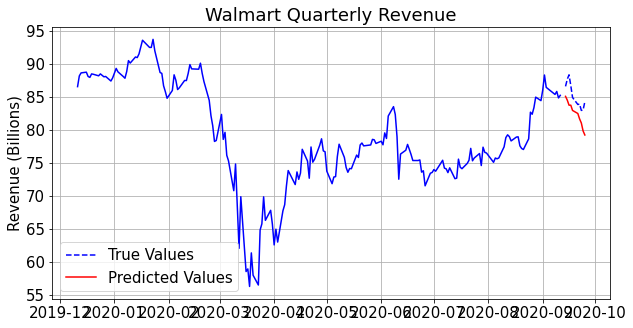

In [134]:
x = [dt.datetime.date(d) for d in df.index]
font = {'size'   : 15}

mpl.rc('font', **font)
fig = plt.figure(figsize=(10,5))
plt.title('Walmart Quarterly Revenue')
plt.ylabel('Revenue (Billions)')
plt.grid(True)
plt.plot(x[:-len(predictions)],
         df[:-len(predictions)],
         "b-")
plt.plot(x[-len(predictions):],
         df[-len(predictions):],
         "b--",
         label='True Values')
plt.plot(x[-len(predictions):],
         predictions,
         "r-",
         label='Predicted Values')
plt.legend()
plt.savefig('plot1', dpi=600)